In [140]:
%pylab osx

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['gcd', 'floor', 'hypot', 'isnan', 'fmod', 'log', 'radians', 'cosh', 'log1p', 'sin', 'copysign', 'nan', 'sinh', 'degrees', 'trunc', 'fabs', 'log2', 'tanh', 'tan', 'pi', 'isinf', 'cos', 'inf', 'expm1', 'log10', 'ldexp', 'e', 'ceil', 'gamma', 'sqrt', 'isclose', 'exp', 'frexp', 'isfinite', 'modf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import csv, os
import scipy.optimize
import scipy.special as ss
from math import *
π = np.pi

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [212]:
Res = pd.DataFrame()

def load_folder (path):
    global Res
    for i in range(300):
        itempath = path+"/"+str(i)
        ppath = itempath+"-params.csv"
        if os.path.exists(ppath):
        #    res = {}
            df = pd.read_csv(ppath, sep=',', header=None)
            df = df.set_index(0).T
            if not 'mfpt' in df.columns:
                first_times = np.array(pd.read_csv(itempath+"-ft.csv", names=['ft'])['ft'])
                df['mfpt'] = np.mean(first_times)
                df['fpt_stdev'] = np.std(first_times)
                df['n_traj'] = len(first_times)
                del first_times
                df.T.to_csv(itempath+"-params.csv", header=False, quoting=csv.QUOTE_NONE, sep=',')
            if not 'Delta_t' in df.columns:
                df['Delta_t'] = 50 * 1.5e-6
            df['i'] = i
            if (df['Delta_t']/df['part_m']).iloc[0] < 1e-3 or df['part_m'].iloc[0] < 1e-5:
                Res = Res.append(df, ignore_index=True, sort=False)

#load_folder("data-poisson-fix-m0")
#load_folder("data-poisson-fix")

load_folder("data-poisson-x0var-m0")
#load_folder("data-poisson-x0var")

load_folder("data-poisson-x0var-m0-loctarg")

len(Res)

107

In [217]:
Res['tau'] = 4*Res['D']*Res['mfpt']/Res['L']**2
Res['tau_err'] = 4*Res['D']*(Res['fpt_stdev']/np.sqrt(Res['n_traj']))/Res['L']**2

## Analyse pour $b=\infty$

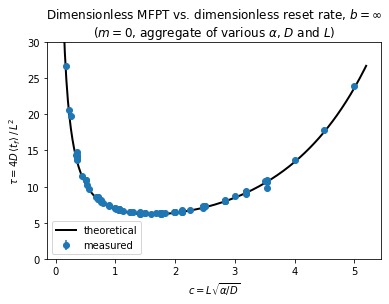

In [146]:
plt.errorbar(Res['c'], Res['tau'], yerr=Res['tau_err'], fmt='o', label="measured")
c = np.linspace(0.1,5.2,200)
tau_binf_th = lambda c: 4/c**2 * ( np.exp(c) - 1 )
plt.plot(c, tau_binf_th(c), label=r"theoretical", color='black', lw=2)
plt.ylim((0,30))
plt.legend(loc='lower left')
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau=4D\,\langle t_f\rangle\,/\,L^2$")
#plt.title(r"MFPT adimentionné (agrégation pour différents paramètres)")
#plt.title(r"Dimensionless MFPT vs. dimensionless reset rate, $b=\infty$"+"\n"+r"($m/\gamma=2\cdot 10^{-4}$, aggregate of various $\alpha$, $D$ and $L$)")
plt.title(r"Dimensionless MFPT vs. dimensionless reset rate, $b=\infty$"+"\n"+r"($m=0$, aggregate of various $\alpha$, $D$ and $L$)")
plt.savefig("langevin-mfpt-c-b_inf.pdf", bbox_inches='tight')

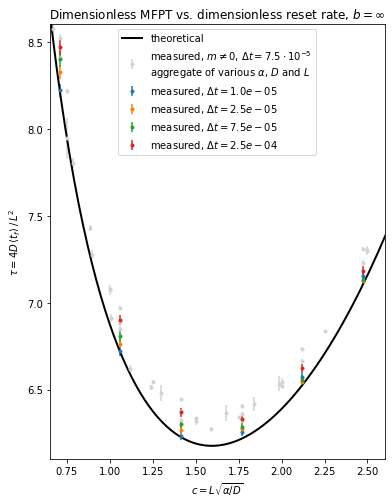

In [186]:
plt.figure(figsize=(6,8))
Res_mn0 = Res[ Res['part_m'] > 1e-3 ]
plt.errorbar(Res_mn0['c'], Res_mn0['tau'], yerr=Res_mn0['tau_err'], fmt='.', label=r"measured, $m\neq 0$, $\Delta t = 7.5\cdot 10^{-5}$"+"\n"+r"aggregate of various $\alpha$, $D$ and $L$", color='lightgray')
groups = Res[ Res['part_m'] < 1e-3 ].sort_values(by='Delta_t').groupby( Res['Delta_t'].apply(lambda x: round(x,6)) )
for Δt, Res_Δt in list(groups):
    plt.errorbar(Res_Δt['c'], Res_Δt['tau'], yerr=Res_Δt['tau_err'], fmt='.', label=r"measured, $\Delta t={:.1e}$".format(Δt))
c = np.linspace(0.1,5.2,200)
plt.plot(c, tau_binf_th(c), label=r"theoretical", color='black', lw=2)
plt.ylim((6.1,8.6))
plt.xlim((0.65,2.6))
plt.legend(loc='upper center')
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau=4D\,\langle t_f\rangle\,/\,L^2$")
#plt.title(r"MFPT adimentionné (agrégation pour différents paramètres)")
#plt.title(r"Dimensionless MFPT vs. dimensionless reset rate, $b=\infty$"+"\n"+r"($m/\gamma=2\cdot 10^{-4}$, aggregate of various $\alpha$, $D$ and $L$)")
plt.title(r"Dimensionless MFPT vs. dimensionless reset rate, $b=\infty$")
plt.savefig("langevin-mfpt-c-b_inf-zoom.pdf", bbox_inches='tight')

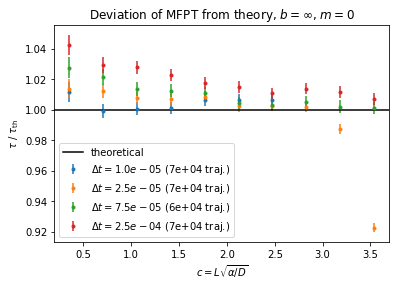

In [187]:
for Δt, Res_Δt in list(groups):
    plt.errorbar(Res_Δt['c'], Res_Δt['tau']/tau_binf_th(Res_Δt['c']), yerr=Res_Δt['tau_err']/tau_binf_th(Res_Δt['c']), fmt='.', label=r"$\Delta t={:.1e}$ ({:.0e} traj.)".format(Δt,Res_Δt['n_traj'].iloc[0]))
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau\ /\ \tau_\operatorname{th}$")
plt.axhline(y=1, color='black', label="theoretical")
plt.legend()
plt.title(r"Deviation of MFPT from theory, $b=\infty$, $m=0$")
plt.savefig("langevin-mfpt-c-b_inf-deviation.pdf", bbox_inches='tight')

,D,T,gamma,part_m,reset_rate,x0sigma,L,c,mfpt,fpt_stdev,n_traj,Delta_t,i,b,tau,tau_err,mfpt_err
24,0.04,20.0,500.0,0.1,1.00,0.0,0.3,1.500000,3.563325,3.591591,661231.0,0.000075,24,NaN,6.334800,0.007852,0.004417
34,0.04,20.0,500.0,0.1,2.00,0.0,0.3,2.121320,3.788232,3.676179,446090.0,0.000075,34,NaN,6.734634,0.009785,0.005504
54,0.04,20.0,500.0,0.1,0.50,0.0,0.3,1.060660,3.853238,4.207520,254433.0,0.000075,54,NaN,6.850200,0.014829,0.008341
59,0.04,20.0,500.0,0.1,0.25,0.0,0.3,0.750000,4.468386,5.403248,6401.0,0.000075,99,inf,7.943797,0.120063,0.067535
60,0.04,20.0,500.0,0.1,0.75,0.0,0.3,1.299038,3.644174,3.791606,21047.0,0.000075,100,inf,6.478531,0.046463,0.026135
61,0.04,20.0,500.0,0.1,1.25,0.0,0.3,1.677051,3.579752,3.541494,19351.0,0.000075,101,inf,6.364003,0.045260,0.025459
62,0.04,20.0,500.0,0.1,1.75,0.0,0.3,1.984313,3.675830,3.592934,23231.0,0.000075,102,inf,6.534809,0.041908,0.023573
63,0.04,20.0,500.0,0.1,1.50,0.0,0.3,1.837117,3.609195,3.527339,23490.0,0.000075,103,inf,6.416346,0.040915,0.023015


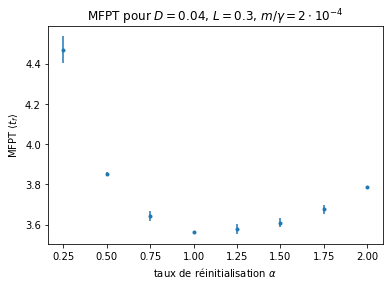

In [4]:
#alpha = np.linspace(0.24,2.02,200)
#plt.plot(alpha, 0.3**2/(4*0.04)*tau_binf_th(0.30*np.sqrt(alpha/0.04)), label=r"théorique", color='black', lw=2)

Res_binf_03 = Res[ (np.abs(Res['L'] - 0.30) < 1e-10) & (np.abs(Res['D'] - 0.04) < 1e-10) ].copy()
Res_binf_03['mfpt_err'] = Res_binf_03['fpt_stdev']/np.sqrt(Res_binf_03['n_traj'])
#Res_binf_03 = Res_binf_03[ Res_binf_03['reset_rate'] > 0.3 ]
plt.errorbar(Res_binf_03['reset_rate'], Res_binf_03['mfpt'], yerr=Res_binf_03['mfpt_err'], fmt='.')
plt.xticks(Res_binf_03['reset_rate'])
plt.xlabel(r"taux de réinitialisation $\alpha$")
plt.ylabel(r"MFPT $\langle t_f\rangle$")
plt.title(r"MFPT pour $D=0.04$, $L=0.3$, $m/\gamma=2\cdot 10^{-4}$")
plt.savefig("langevin-mfpt-alpha-b_inf.pdf", bbox_inches='tight')
Res_binf_03

## Analyse pour $b$ variable

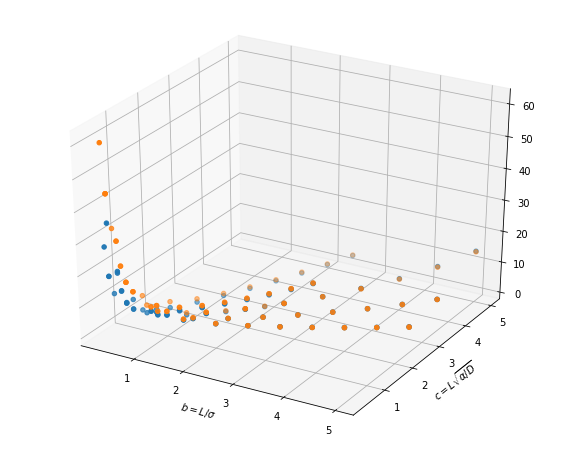

In [208]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter( Res['b'], Res['c'], Res['tau'] )
ax.scatter( Res['b'], Res['c'], tau_th(Res['b'],Res['c']) )
plt.xlabel(r"$b=L/\sigma$")
plt.ylabel(r"$c=L\sqrt{\alpha/D}$")
#plt.zlabel(r"$\tau$")
#plt.savefig("3d-plot.pdf", bbox_inches='tight')
plt.show()

In [215]:
groups = Res.groupby( Res['b'].apply(lambda x: round(x,2)) )
colors = {}
for b, Res_b in list(groups):
    if len(Res_b) > 4:
        colors[b] = None
i = 0
for k in colors.keys():
    colors[k] = matplotlib.colors.hsv_to_rgb((i/len(colors), 1, 1))
    i += 1

tau_th = lambda b,c: 4/c**2 * ( (2*np.exp(-c**2/2/b**2)) / ( np.exp(c)*ss.erfc((c/b+b)/sqrt(2)) + np.exp(-c)*ss.erfc((c/b-b)/sqrt(2)) ) - 1 )

def order_c_tau (Res_b, filter_f=None):
    c = np.array(Res_b['c'])
    i = np.argsort(c)
    c = c[i]
    tau = np.array(Res_b['tau'])[i]
    err = np.array(Res_b['tau_err'])[i]
    if filter_f is not None:
        i = filter_f(c, tau)
        c = c[i]
        tau = tau[i]
        err = err[i]
    return c, tau, err

def annotate_params (Res_b, f_pos = lambda c,tau: (c,tau)):
    for i in range(len(Res_b)):
        res = Res_b.iloc[i]
        # $\Delta t={:.1e}$
        plt.annotate("$\\alpha={}$, $L={:.2f}$, $m={}$, $D={}$".format(res['reset_rate'],res['L'],res['part_m'],res['D']), f_pos(res['c'],res['tau']), size=6, ha='center', va='center')

def annotate_i (Res_b):
    for i in range(len(Res_b)):
        res = Res_b.iloc[i]
        plt.annotate(str(int(res['i'])), (res['c'],res['tau']), size=8, ha='center', va='center')

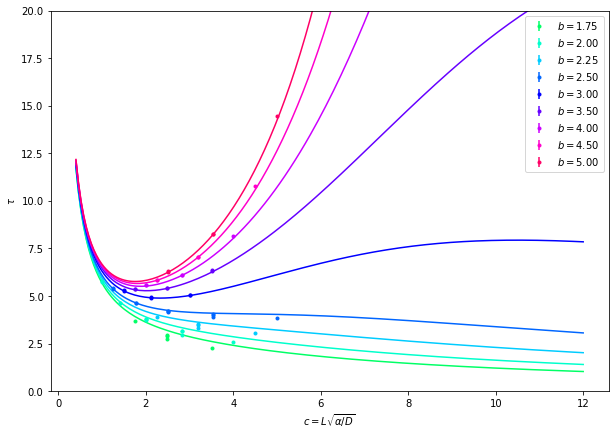

In [218]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b > 1.6 and len(Res_b) > 4:
        c = np.linspace(0.4, 12, 200)
        plt.plot(c, tau_th(b,c), color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=err, fmt='.')
        #annotate_params(Res_b)
        
plt.ylim((0,20))
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau$")
plt.legend()
#plt.savefig("mfpt-poisson-x0var-highb.pdf", bbox_inches='tight')
plt.show()

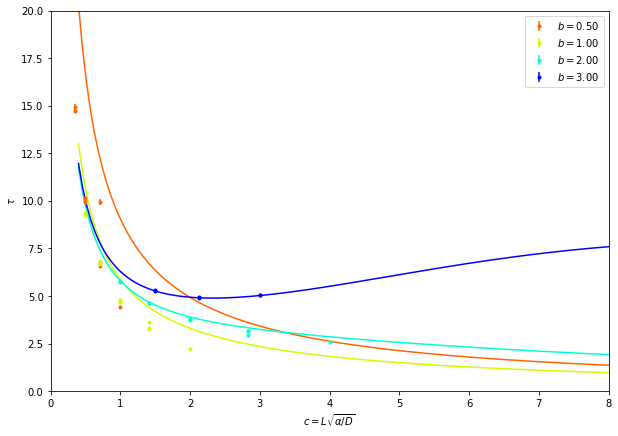

In [219]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b in [0.5,1.0,2.0,3.0]:
        c = np.linspace(0.4, 12, 200)
        plt.plot(c, tau_th(b,c), color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=err, fmt='.')
        #annotate_params(Res_b)
        
plt.ylim((0,20))
plt.xlim((0,8))
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau$")
plt.legend()
#plt.savefig("mfpt-poisson-x0var-commonb.pdf", bbox_inches='tight')
plt.show()

In [25]:
Res[ Res['c'] > 10 ]

,D,T,gamma,part_m,reset_rate,x0sigma,L,b,c,mfpt,fpt_stdev,n_traj,Delta_t,i,tau,tau_err
200,0.004,2.0,500.0,0.1,2.0,0.15,0.45,3.000000,10.062306,90.083447,91.883317,37293.0,0.000075,227,7.117704,0.037594
201,0.004,2.0,500.0,0.1,2.0,0.15,0.50,3.333333,11.180340,218.189737,220.056072,37293.0,0.000075,228,13.964143,0.072929


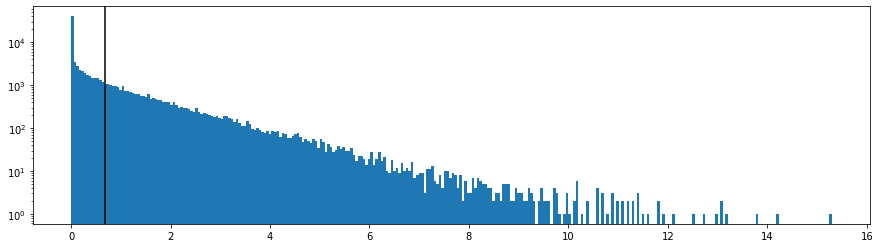

In [37]:
first_times = np.array(pd.read_csv("data-poisson-x0var/200-ft.csv", names=['ft'])['ft'])
plt.figure(figsize=(15,4))
plt.hist(first_times, log=True, bins=300)
plt.axvline(x=np.mean(first_times), color='black')
None

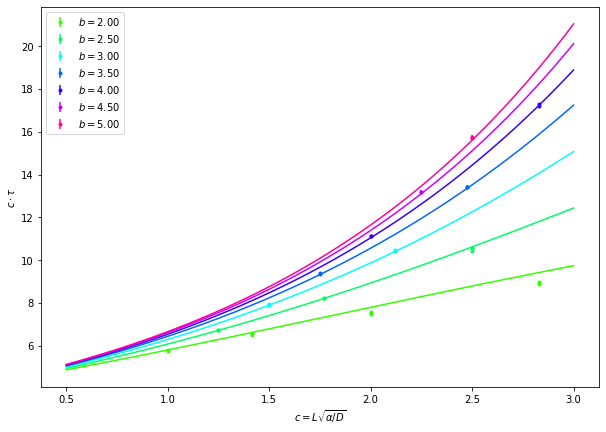

In [192]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b > 1.6 and len(Res_b) > 4:
        c = np.linspace(0.5, 3, 200)
        plt.plot(c, c*tau_th(b,c), color=colors[b])
        c, tau, err = order_c_tau(Res_b, lambda c,_: c < 3)
        plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=c*err, fmt='.')
        #annotate_params(Res_b)
        
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$c\cdot\tau$")
plt.legend()
plt.savefig("mfpt-poisson-x0var-highb-zoom.pdf", bbox_inches='tight')
plt.show()

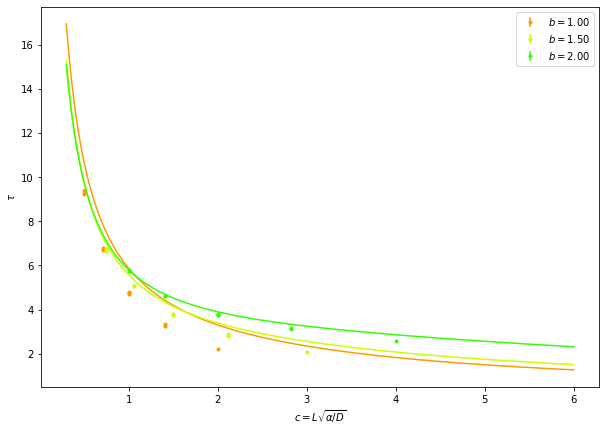

In [170]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b < 2.3 and b > 0.5 and len(Res_b) > 4:
        c = np.linspace(0.3, 6, 200)
        plt.plot(c, tau_th(b,c), color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=err, fmt='.')
        
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$\tau$")
plt.legend()
plt.show()

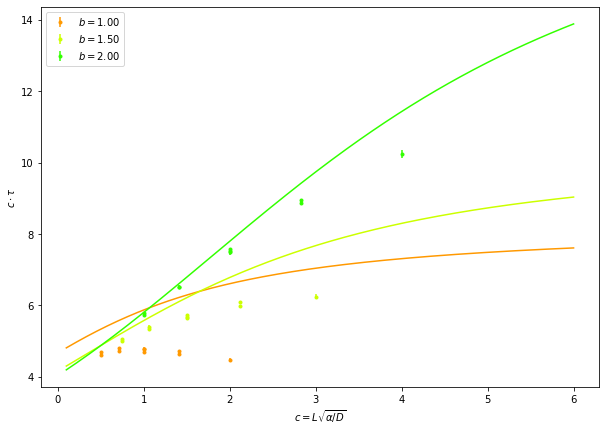

In [193]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b < 2.3 and b > 0.5 and len(Res_b) > 4:
        c = np.linspace(0.1, 6, 200)
        plt.plot(c, c*tau_th(b,c), color=colors[b])
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), color=colors[b], yerr=c*err, fmt='.')
        
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$c\cdot\tau$")
plt.legend()
plt.savefig("mfpt-poisson-x0var-lowb-zoom.pdf", bbox_inches='tight')
plt.show()

In [39]:
np.min(Res['mfpt'])

0.21507629150188268

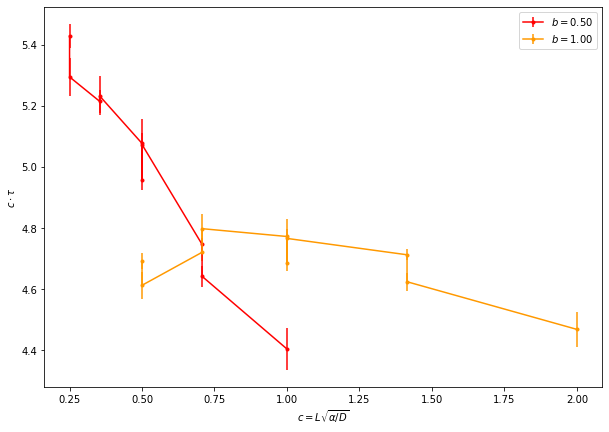

In [173]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if b < 1.1 and len(Res_b) > 4:
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), yerr=c*err, fmt='.-', color=colors[b])
        
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$c\cdot\tau$")
plt.legend()
plt.show()

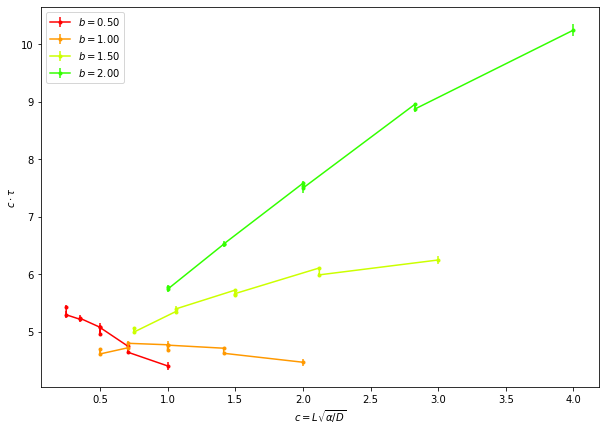

In [174]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if len(Res_b) > 4 and b <= 2:
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), yerr=c*err, fmt='.-', color=colors[b])
        
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$c\cdot\tau$")
plt.legend()
plt.savefig("mfpt-poisson-x0var-lowb-points.pdf", bbox_inches='tight')
plt.show()

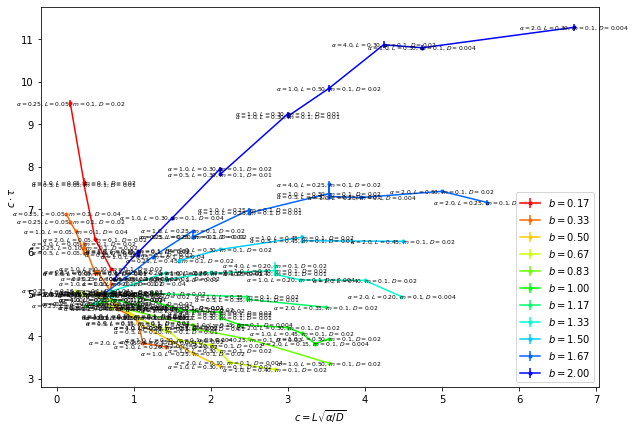

In [33]:
plt.figure(figsize=(10,7))
for b, Res_b in list(groups):
    
    if len(Res_b) > 3 and b <= 2:
        c, tau, err = order_c_tau(Res_b)
        plt.errorbar(c, c*tau, label=r"$b={:.2f}$".format(b), yerr=c*err, fmt='.-', color=colors[b])
        annotate_params(Res_b, f_pos = lambda c,tau: (c,c*tau))
        
plt.xlabel(r"$c=L\sqrt{\alpha/D}$")
plt.ylabel(r"$c\cdot\tau$")
plt.legend()
plt.show()